# Import packages

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from func import get_user_movie_rating_dict, get_similarity_dict, jaccard_similarity, cosine_similarity, \
centred_cosine_similarity, pearson_similarity, predict_ratings
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
from sklearn import preprocessing
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

In [2]:
def tokenize(movies):

#   add a new column to the movies, which contains lists of words from genres
    tokenlist=[]
    for index,row in movies.iterrows():
        tokenlist.append(tokenize_string(row.genres))
    movies['tokens']=tokenlist
    return movies

def tokenize_string(my_string):
#     split by |
    return my_string.split(',');


# Read in Data

In [3]:
movie_original_df = pd.read_csv('mubi_movie_data.csv')

In [4]:
# movie genres
movie_df = pd.read_csv('movie_genres_after_all_match.csv').drop('Unnamed: 0',axis=1)

In [5]:
# movie ratings
movie_ratings = pd.read_csv('mubi_ratings_data.csv')

/Users/j/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
movie_ratings.head()

,movie_id,rating_id,rating_url,rating_score,rating_timestamp_utc,critic,critic_likes,critic_comments,user_id,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
0,1066,15610495,http://mubi.com/films/pavee-lackeen-the-travel...,3.0,2017-06-10 12:38:33,NaN,0,0,41579158,False,False,True,False
1,1066,10704606,http://mubi.com/films/pavee-lackeen-the-travel...,2.0,2014-08-15 23:42:31,NaN,0,0,85981819,True,True,False,True
2,1066,10177114,http://mubi.com/films/pavee-lackeen-the-travel...,2.0,2014-01-30 13:21:57,NaN,0,0,4208563,False,False,True,True
3,1066,10130280,http://mubi.com/films/pavee-lackeen-the-travel...,3.0,2014-01-19 01:04:23,I am a bit disappointed by this documentary fi...,0,0,9820140,False,False,True,False
4,1066,8357049,http://mubi.com/films/pavee-lackeen-the-travel...,4.0,2012-10-02 18:28:47,NaN,0,0,68654088,False,False,True,True


In [7]:
movie_ratings.shape

(15520005, 13)

In [8]:
movie_user = pd.read_csv('mubi_ratings_user_data.csv')

/Users/j/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
movie_user.shape

(4297641, 8)

# Clean Data

In [10]:
# Valid movie list filtered by similariyt >= 0.85
valid_list = movie_df[movie_df.title_similarity >=0.85].mubi_id

In [11]:
# Movie dataframe of valid movies
movie_valid_df = movie_df[movie_df.mubi_id.isin(valid_list)].copy()

In [12]:
# Movie ratings of valid movies 
movie_valid_ratings = movie_ratings[movie_ratings.movie_id.isin(valid_list)].copy()

In [13]:
# Drop na ratings
movie_final_ratings = movie_valid_ratings[-movie_valid_ratings.rating_score.isna()].copy()

In [14]:
rating_counts = movie_final_ratings.shape[0]

In [15]:
for i in (range(1,6)):
    print('Rating score {} makes up for {}% of all rating records'.format(i, \
                            movie_final_ratings[movie_final_ratings.rating_score == i].shape[0]/rating_counts * 100))


Rating score 1 makes up for 4.968503333122736% of all rating records
Rating score 2 makes up for 11.12282872333848% of all rating records
Rating score 3 makes up for 26.771886424826775% of all rating records
Rating score 4 makes up for 34.0641393428084% of all rating records
Rating score 5 makes up for 23.072642175903603% of all rating records


# Generate sample dataset

In [16]:
# Get all user id
whole_user_id_list = movie_final_ratings.user_id.unique()

In [17]:
len(whole_user_id_list)

434010

In [18]:
# sample_size = 43000 # around 10%

In [19]:
# # sample user id
# user_id_sample_list = pd.Series(whole_user_id_list).sample(sample_size)

In [20]:
# sample ratings dataframe
movie_sample_ratings = movie_final_ratings.copy()

In [21]:
# sort df by time stamp
movie_sample_ratings = movie_sample_ratings.sort_values('rating_timestamp_utc')

In [22]:
# Keep useful columns only
trntst_sample_ratings = movie_sample_ratings[['user_id','movie_id','rating_score','rating_timestamp_utc']]\
.reset_index().drop('index',axis=1)

In [23]:
trntst_sample_ratings

,user_id,movie_id,rating_score,rating_timestamp_utc
0,35397635,196,4.0,1970-01-01 00:00:00
1,30969152,19472,4.0,1970-01-01 00:00:00
2,49985304,24,3.0,2008-02-01 01:01:43
3,49985304,12,5.0,2008-02-01 01:01:45
4,49985304,13,4.0,2008-02-01 01:01:50
...,...,...,...,...
14799180,65863490,263553,4.0,2020-04-26 08:21:27
14799181,38514533,263011,5.0,2020-04-26 08:41:53
14799182,7474324,262277,3.0,2020-04-26 08:46:28
14799183,45566853,263010,4.0,2020-04-26 09:16:00


In [27]:
# train test size around 98%/2%
train_sample_ratings = trntst_sample_ratings.head(14300000)
test_sample_ratings = trntst_sample_ratings.tail(trntst_sample_ratings.shape[0]-14300000)

In [28]:
train_sample_ratings

,user_id,movie_id,rating_score,rating_timestamp_utc
0,35397635,196,4.0,1970-01-01 00:00:00
1,30969152,19472,4.0,1970-01-01 00:00:00
2,49985304,24,3.0,2008-02-01 01:01:43
3,49985304,12,5.0,2008-02-01 01:01:45
4,49985304,13,4.0,2008-02-01 01:01:50
...,...,...,...,...
14299995,59508128,1958,4.0,2020-01-25 16:44:13
14299996,48239614,214405,1.0,2020-01-25 16:44:32
14299997,99392170,21346,3.0,2020-01-25 16:44:33
14299998,59508128,2057,3.0,2020-01-25 16:44:34


In [29]:
test_sample_ratings

,user_id,movie_id,rating_score,rating_timestamp_utc
14300000,59508128,252,3.0,2020-01-25 16:44:49
14300001,47518463,234416,4.0,2020-01-25 16:45:34
14300002,20173681,133345,1.0,2020-01-25 16:46:29
14300003,81634675,963,5.0,2020-01-25 16:46:36
14300004,37261851,141,3.0,2020-01-25 16:46:56
...,...,...,...,...
14799180,65863490,263553,4.0,2020-04-26 08:21:27
14799181,38514533,263011,5.0,2020-04-26 08:41:53
14799182,7474324,262277,3.0,2020-04-26 08:46:28
14799183,45566853,263010,4.0,2020-04-26 09:16:00


# Cluster movies

In [30]:
start = time.time()
movie_tokenized = tokenize(movie_valid_df)
print(time.time()-start)

14.714893817901611


In [31]:
# Get the set of all genres
genres_set = set()
for i in tqdm(movie_tokenized.tokens):
    for k in i:
        if k not in genres_set:
            genres_set.add(k)

100%|██████████| 173881/173881 [00:00<00:00, 1562427.21it/s]


In [32]:
len(genres_set)
# 29 different categories including N/A

29

In [33]:
# Add columns for all 29 categories
movie_valid_len = len(movie_valid_df)
for cat in genres_set:
    movie_valid_df[cat] = np.zeros(movie_valid_len)


In [34]:
movie_valid_df

,mubi_id,mubi_release_year,mubi_title,imdb_title,title_similarity,genres,tokens,Sport,Romance,Game-Show,Talk-Show,Drama,Thriller,Documentary,News,Reality-TV,Film-Noir,Biography,Mystery,War,Action,Short,Horror,Music,Crime,Adult,\N,Fantasy,Family,Sci-Fi,Animation,Western,Adventure,Musical,Comedy,History
0,1,2007.0,La Antena,La antena,1.000000,"Drama,Fantasy,Sci-Fi","[Drama, Fantasy, Sci-Fi]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2006.0,Elementary Particles,The Elementary Particles,0.909091,"Drama,Romance","[Drama, Romance]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2006.0,It's Winter,It's Winter,1.000000,Drama,[Drama],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2005.0,Kirikou and the Wild Beasts,Kirikou and the Wild Beasts,1.000000,"Adventure,Animation,Family","[Adventure, Animation, Family]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,2005.0,Riviera,Riviera,1.000000,Drama,[Drama],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226567,263703,2014.0,Miss Earth,Miss Earth,1.000000,"Sci-Fi,Short","[Sci-Fi, Short]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226568,263704,2015.0,Loose Ends,Loose Ends,1.000000,"Drama,Short","[Drama, Short]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226569,263705,1932.0,Una notte con te,Una notte con te,1.000000,Comedy,[Comedy],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226570,263706,2020.0,Kill Chain: The Cyber War on America's Elections,Kill Chain: The Cyber War on America's Elections,1.000000,Documentary,[Documentary],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Allocate genres info for each movie
for idx in tqdm(movie_valid_df.index):
    tmp_tokens = movie_valid_df.loc[idx,'tokens']
    for token in tmp_tokens:
        movie_valid_df.loc[idx,token] = 1


100%|██████████| 173881/173881 [03:12<00:00, 901.50it/s] 


In [36]:
# Categorize movies by release year
movie_valid_df['<1900'] = np.zeros(movie_valid_len)
movie_valid_df['1900~1919'] = np.zeros(movie_valid_len)
movie_valid_df['1920~1939'] = np.zeros(movie_valid_len)
movie_valid_df['1940~1959'] = np.zeros(movie_valid_len)
movie_valid_df['1960~1969'] = np.zeros(movie_valid_len)
movie_valid_df['1970~1979'] = np.zeros(movie_valid_len)
movie_valid_df['1980~1989'] = np.zeros(movie_valid_len)
movie_valid_df['1990~1994'] = np.zeros(movie_valid_len)
movie_valid_df['1995~1999'] = np.zeros(movie_valid_len)
movie_valid_df['2000~2004'] = np.zeros(movie_valid_len)
movie_valid_df['2005~2009'] = np.zeros(movie_valid_len)
movie_valid_df['2010~2012'] = np.zeros(movie_valid_len)
movie_valid_df['2013~2015'] = np.zeros(movie_valid_len)
movie_valid_df['2016~2018'] = np.zeros(movie_valid_len)
movie_valid_df['2019~2020'] = np.zeros(movie_valid_len)

In [37]:
for idx in movie_valid_df.index:
    y = movie_valid_df.loc[idx,'mubi_release_year']
    if y < 1900:
        movie_valid_df.loc[idx,'<1900'] = 1
    elif 1900<=y<=1919:
        movie_valid_df.loc[idx,'1900~1919'] = 1
    elif 1920<=y<=1939:
        movie_valid_df.loc[idx,'1920~1939'] = 1
    elif 1940<=y<=1959:
        movie_valid_df.loc[idx,'1940~1959'] = 1
    elif 1960<=y<=1969:
        movie_valid_df.loc[idx,'1960~1969'] = 1
    elif 1970<=y<=1979:
        movie_valid_df.loc[idx,'1970~1979'] = 1
    elif 1980<=y<=1989:
        movie_valid_df.loc[idx,'1980~1989'] = 1
    elif 1990<=y<=1994:
        movie_valid_df.loc[idx,'1990~1994'] = 1
    elif 1995<=y<=1999:
        movie_valid_df.loc[idx,'1995~1999'] = 1
    elif 2000<=y<=2004:
        movie_valid_df.loc[idx,'2000~2004'] = 1
    elif 2005<=y<=2009:
        movie_valid_df.loc[idx,'2005~2009'] = 1
    elif 2010<=y<=2012:
        movie_valid_df.loc[idx,'2010~2012'] = 1
    elif 2013<=y<=2015:
        movie_valid_df.loc[idx,'2013~2015'] = 1
    elif 2016<=y<=2018:
        movie_valid_df.loc[idx,'2016~2018'] = 1
    elif 2019<=y:
        movie_valid_df.loc[idx,'2019~2020'] = 1
        

In [38]:
# Add a mean score column for each movie by training dataset
# If movie doesn't exist in training set, then use the global average
# This step takes place on whole dataset
training_mean_df = movie_valid_ratings.sort_values('rating_timestamp_utc')[['movie_id','rating_score']]\
.head(14300000).groupby('movie_id').mean()


In [39]:
training_mean_df_index = training_mean_df.index
training_mean_df_values = training_mean_df_index.values

In [40]:
global_avg = movie_valid_ratings.sort_values('rating_timestamp_utc')[['movie_id','rating_score']]\
.head(14300000).mean()[1]

In [41]:
# Add mean score to each movie
for idx in tqdm(movie_valid_df.index):
    mv_id = movie_valid_df.loc[idx,'mubi_id']
    if mv_id in training_mean_df_index:
        movie_valid_df.loc[idx,'mean_score'] = training_mean_df.loc[mv_id][0]
    else:
        movie_valid_df.loc[idx,'mean_score'] = global_avg


100%|██████████| 173881/173881 [02:44<00:00, 1055.09it/s]


In [42]:
# Fill na values
movie_valid_df['mean_score'] = movie_valid_df.mean_score.fillna(global_avg)

## Scaling data before clustering 

In [43]:
movie_before_kmeans = movie_valid_df.reset_index().drop('index',axis=1).copy()

In [44]:
# save a series for checking
movie_check_list = movie_before_kmeans[['mubi_id']].copy()

In [45]:
# Merge movie data with popularity score
movie_pop = movie_original_df[['movie_id','movie_popularity']]
movie_pop.columns = ['mubi_id','movie_popularity']

In [46]:
movie_before_kmeans = movie_before_kmeans.merge(movie_pop,on='mubi_id')

In [47]:
movie_before_kmeans = movie_before_kmeans.drop(['mubi_id','mubi_release_year','mubi_title',
                                               'imdb_title','title_similarity','genres','tokens'],axis=1)

In [48]:
min_max_scaler = preprocessing.MinMaxScaler()

In [49]:
# Scale data for several columns

In [50]:
movie_before_kmeans['mean_score'] = \
min_max_scaler.fit_transform(movie_before_kmeans['mean_score'].values.reshape(-1,1))

In [51]:
movie_before_kmeans['movie_popularity'] = \
min_max_scaler.fit_transform(movie_before_kmeans['movie_popularity'].values.reshape(-1,1))

In [52]:
movie_before_kmeans

,Sport,Romance,Game-Show,Talk-Show,Drama,Thriller,Documentary,News,Reality-TV,Film-Noir,Biography,Mystery,War,Action,Short,Horror,Music,Crime,Adult,\N,Fantasy,Family,Sci-Fi,Animation,Western,Adventure,Musical,Comedy,History,<1900,1900~1919,1920~1939,1940~1959,1960~1969,1970~1979,1980~1989,1990~1994,1995~1999,2000~2004,2005~2009,2010~2012,2013~2015,2016~2018,2019~2020,mean_score,movie_popularity
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.695749,0.007506
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.469538,0.001644
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.606183,0.001501
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.702596,0.003288
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.503731,0.000357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.646634,0.000000
173877,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.646634,0.000000
173878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.646634,0.000000
173879,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.646634,0.000000


In [53]:
movie_before_kmeans.to_csv('movie_befroe_kmean_scaled.csv')

## Perform K means method

In [54]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,100) 
  
for k in tqdm(K): 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(movie_before_kmeans) 
    kmeanModel.fit(movie_before_kmeans)     
      
    distortions.append(sum(np.min(cdist(movie_before_kmeans, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / movie_before_kmeans.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(movie_before_kmeans, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / movie_before_kmeans.shape[0] 
    mapping2[k] = kmeanModel.inertia_
#     if k >1:
#         score = silhouette_score(movie_before_kmeans, kmeanModel.labels_)
#         print('k= {}, {}, score= {}'.format(k,kmeanModel.inertia_, score))

100%|██████████| 99/99 [45:17<00:00, 27.45s/it]


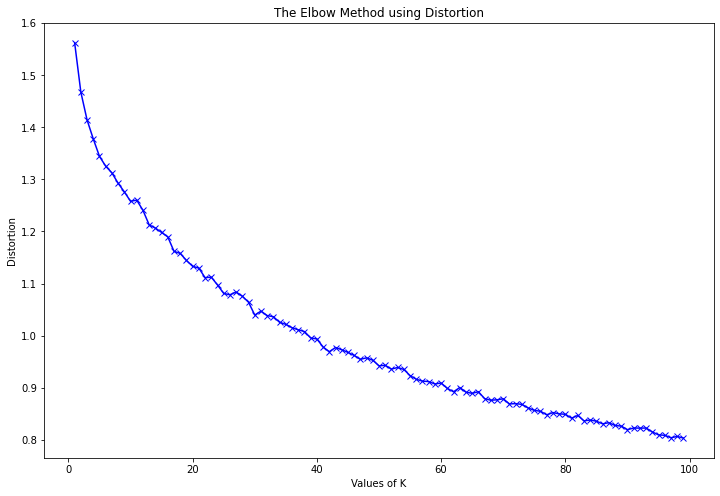

In [55]:
plt.figure(figsize = (12,8))
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

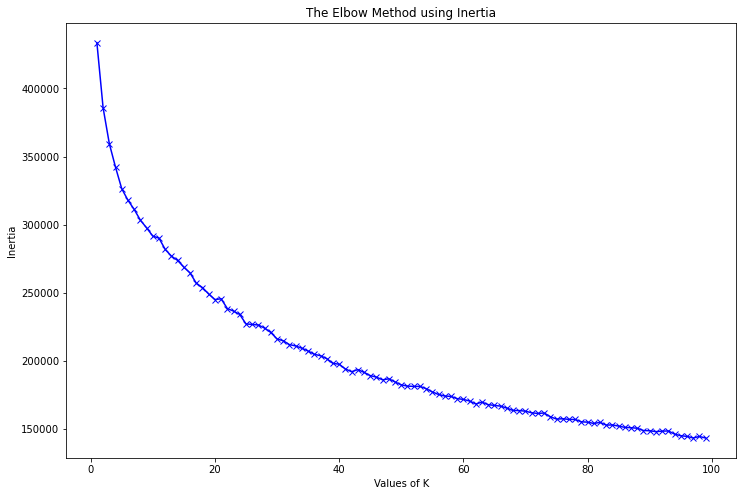

In [56]:
plt.figure(figsize = (12,8))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [57]:
# Choose K=25

In [60]:
k=25
kmeanModel = KMeans(n_clusters=k).fit(movie_before_kmeans) 
kmeanModel.fit(movie_before_kmeans)     

KMeans(n_clusters=25)

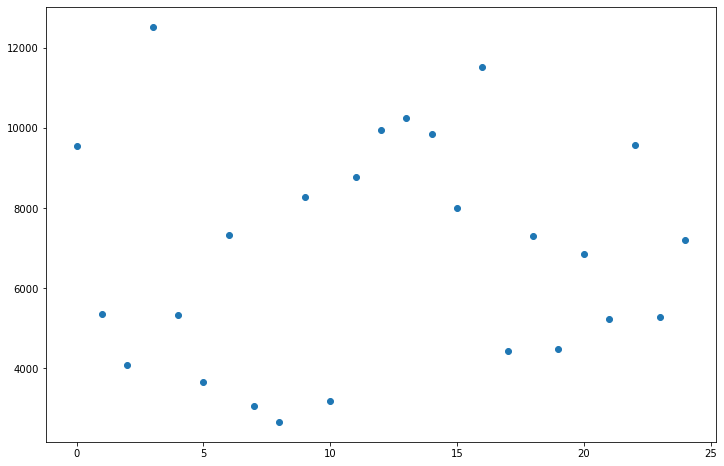

In [61]:
plt.figure(figsize=(12,8))
plt.scatter(pd.Series(kmeanModel.labels_).value_counts().index,\
            pd.Series(kmeanModel.labels_).value_counts().values)
plt.show()

In [62]:
movie_check_list['label'] = kmeanModel.labels_

In [63]:
movie_check_list.to_csv('Movie_clusters_K25.csv')

# Cluster users

In [64]:
# Cluster all users that showed up in training dataset
# Don't include users that showed up in test dataset
# So need to face cold start problems
# For cold start users, use global average + movie bias
# For cold start movies, use global average + user bias
# For both cold starts, use global average

In [65]:
# Dataframe for movie_id and labels
movie_cluster_df = movie_check_list.copy()
movie_cluster_df.columns = ['movie_id','movie_cluster']

In [67]:
# Join cluster lables to ratings dataframe
train_sample_ratings = train_sample_ratings.merge(movie_cluster_df,on='movie_id')

In [68]:
# Create the unique user list for training dataset
train_sample_user_list = train_sample_ratings.user_id.unique()
train_sample_user_list.sort()

In [69]:
# Create user dataframe for clustering
# k is the number of clusters
cols = ['user_id','total_num']
for i in tqdm(range(k)):
    cols.append('count_cluster{}'.format(i))
    cols.append('mean_score_cluster{}'.format(i))
sample_user_cluster_df = pd.DataFrame(0, index = range(len(train_sample_user_list)), columns = cols)
sample_user_cluster_df['user_id'] = train_sample_user_list


100%|██████████| 25/25 [00:00<00:00, 27413.75it/s]


In [70]:
# count the total number movies watched for each user \
sample_user_cluster_df.total_num = train_sample_ratings.groupby(['user_id']).count()['rating_score'].reset_index()['rating_score']

In [71]:
# Reference table for number of movies watched
train_ref_count = train_sample_ratings.groupby(['user_id','movie_cluster']).count()[['rating_score']]
train_ref_count.columns = [['total_num']]

In [72]:
# Reference table for average score of movies watched for each cluster
train_ref_avg = train_sample_ratings.groupby(['user_id','movie_cluster']).mean()[['rating_score']]
train_ref_avg.columns = [['mean_score']]

In [76]:
# Finish user cluster raw table
for idx in tqdm(train_ref_count.index):
    user_id = idx[0]
    clus = idx[1]
    cat1 = 'count_cluster{}'.format(clus)
    cat2 = 'mean_score_cluster{}'.format(clus)
    df_index = sample_user_cluster_df[sample_user_cluster_df.user_id == user_id].index
    sample_user_cluster_df.loc[df_index,cat1] = train_ref_count.loc[idx][0]
    sample_user_cluster_df.loc[df_index,cat2] = train_ref_avg.loc[idx][0]


100%|██████████| 1831646/1831646 [2:40:26<00:00, 190.28it/s]  


In [77]:
# Get the check user list
sample_user_check_list = sample_user_cluster_df[['user_id']]

In [78]:
# Drop user id
sample_user_cluster_df = sample_user_cluster_df.drop('user_id',axis=1)

In [79]:
# Scale data
sample_user_cluster_after_scaling = sample_user_cluster_df.copy()
for col in tqdm(sample_user_cluster_df.columns):
    sample_user_cluster_after_scaling[col] = \
    min_max_scaler.fit_transform(sample_user_cluster_df[col].values.reshape(-1,1))


100%|██████████| 51/51 [00:00<00:00, 71.39it/s]


In [80]:
sample_user_cluster_after_scaling

,total_num,count_cluster0,mean_score_cluster0,count_cluster1,mean_score_cluster1,count_cluster2,mean_score_cluster2,count_cluster3,mean_score_cluster3,count_cluster4,mean_score_cluster4,count_cluster5,mean_score_cluster5,count_cluster6,mean_score_cluster6,count_cluster7,mean_score_cluster7,count_cluster8,mean_score_cluster8,count_cluster9,mean_score_cluster9,count_cluster10,mean_score_cluster10,count_cluster11,mean_score_cluster11,...,mean_score_cluster12,count_cluster13,mean_score_cluster13,count_cluster14,mean_score_cluster14,count_cluster15,mean_score_cluster15,count_cluster16,mean_score_cluster16,count_cluster17,mean_score_cluster17,count_cluster18,mean_score_cluster18,count_cluster19,mean_score_cluster19,count_cluster20,mean_score_cluster20,count_cluster21,mean_score_cluster21,count_cluster22,mean_score_cluster22,count_cluster23,mean_score_cluster23,count_cluster24,mean_score_cluster24
0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00076,1.0,...,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000646,0.003727,0.8,0.001115,0.6,0.0,0.0,0.000694,0.8,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.003731,0.4,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.006116,0.55,0.0,0.0,0.001072,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001278,0.9
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.001005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00113,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,1.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392784,0.000215,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000694,0.6,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.003731,0.6,0.0,0.0,0.00000,0.0,...,0.0,0.001097,0.8,0.001529,0.80,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
392785,0.000108,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000694,0.4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.003731,0.8,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.001529,1.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
392786,0.000269,0.000000,0.0,0.001115,0.6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00165,1.0,0.0,0.0,0.002304,0.8,0.000000,0.0,0.0,0.0,0.00152,0.8,...,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000639,0.8
392787,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.001005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Perform Kmeans

In [81]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,50) 
  
for n_clus in tqdm(K): 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=n_clus).fit(sample_user_cluster_after_scaling) 
    kmeanModel.fit(sample_user_cluster_after_scaling)     
      
    distortions.append(sum(np.min(cdist(sample_user_cluster_after_scaling, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / sample_user_cluster_after_scaling.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(sample_user_cluster_after_scaling, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / sample_user_cluster_after_scaling.shape[0] 
    mapping2[k] = kmeanModel.inertia_
#     if k >1:
#         score = silhouette_score(movie_before_kmeans, kmeanModel.labels_)
#         print('k= {}, {}, score= {}'.format(k,kmeanModel.inertia_, score))

100%|██████████| 49/49 [7:24:41<00:00, 544.52s/it]   


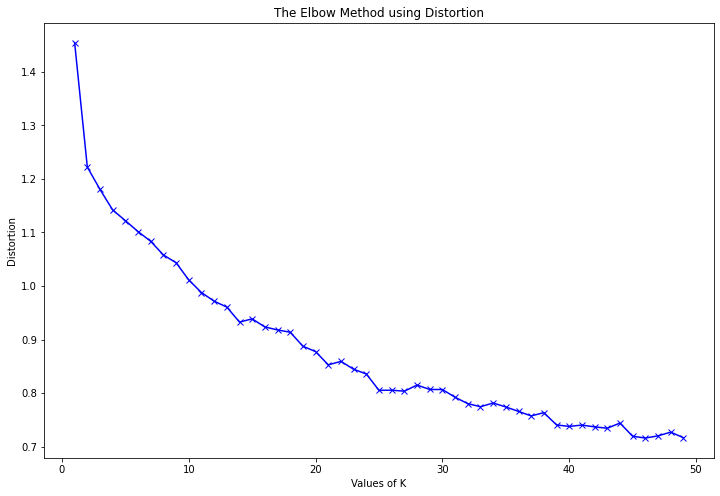

In [82]:
plt.figure(figsize = (12,8))
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

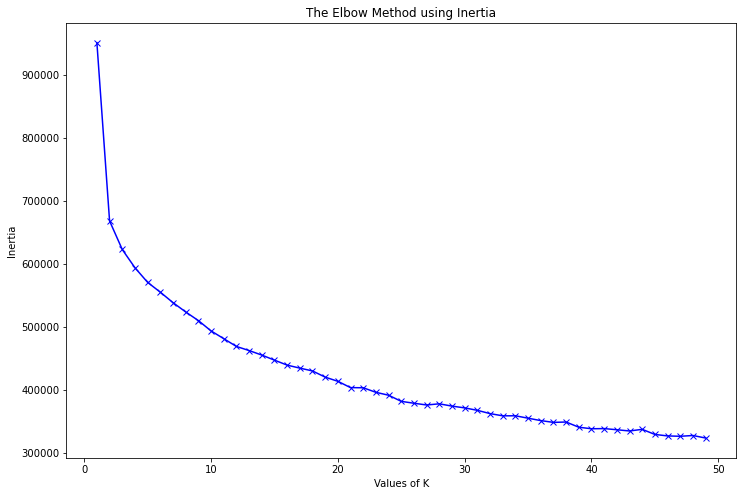

In [83]:
plt.figure(figsize = (12,8))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [84]:
# K=14 clusters

In [85]:
# distortions = [] 
# inertias = [] 
# mapping1 = {} 
# mapping2 = {} 
# K = range(1,100) 
  
# for n_clus in tqdm(K): 
    #Building and fitting the model
n_clus = 14
kmeanModel = KMeans(n_clusters=n_clus).fit(sample_user_cluster_after_scaling) 
kmeanModel.fit(sample_user_cluster_after_scaling)     

# distortions.append(sum(np.min(cdist(sample_user_cluster_after_scaling, kmeanModel.cluster_centers_, 
#                   'euclidean'),axis=1)) / sample_user_cluster_after_scaling.shape[0]) 
# inertias.append(kmeanModel.inertia_) 

# mapping1[k] = sum(np.min(cdist(sample_user_cluster_after_scaling, kmeanModel.cluster_centers_, 
#              'euclidean'),axis=1)) / sample_user_cluster_after_scaling.shape[0] 
# mapping2[k] = kmeanModel.inertia_
#     if k >1:
#         score = silhouette_score(movie_before_kmeans, kmeanModel.labels_)
#         print('k= {}, {}, score= {}'.format(k,kmeanModel.inertia_, score))

KMeans(n_clusters=14)

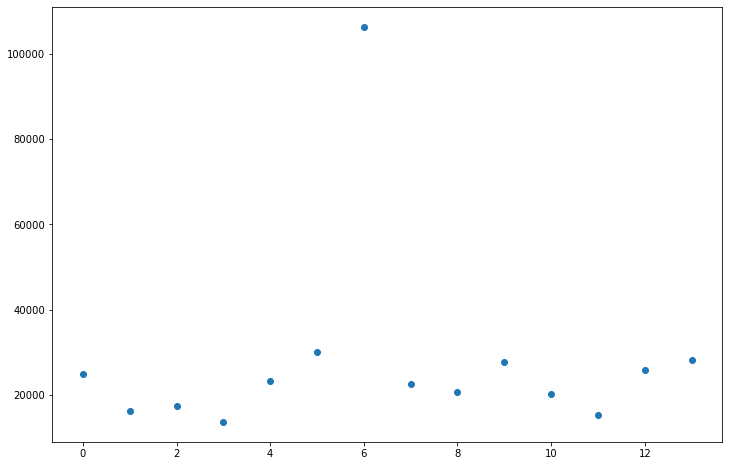

In [86]:
plt.figure(figsize=(12,8))
plt.scatter(pd.Series(kmeanModel.labels_).value_counts().index,\
            pd.Series(kmeanModel.labels_).value_counts().values)
plt.show()

In [87]:
# Add label to dataframe
sample_user_check_list['user_cluster'] = kmeanModel.labels_

/Users/j/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
sample_user_check_list.head()

,user_id,user_cluster
0,57,5
1,176,2
2,181,4
3,499,9
4,606,6


In [90]:
sample_user_check_list.to_csv('sample_user_cluster_entire_cluster.csv')

In [91]:
# Create a user cluster centroid dataframe
sample_user_cluster_centroid = pd.DataFrame(kmeanModel.cluster_centers_,
                                           index=range(n_clus),columns = sample_user_cluster_after_scaling.columns)

In [92]:
sample_user_cluster_centroid

,total_num,count_cluster0,mean_score_cluster0,count_cluster1,mean_score_cluster1,count_cluster2,mean_score_cluster2,count_cluster3,mean_score_cluster3,count_cluster4,mean_score_cluster4,count_cluster5,mean_score_cluster5,count_cluster6,mean_score_cluster6,count_cluster7,mean_score_cluster7,count_cluster8,mean_score_cluster8,count_cluster9,mean_score_cluster9,count_cluster10,mean_score_cluster10,count_cluster11,mean_score_cluster11,...,mean_score_cluster12,count_cluster13,mean_score_cluster13,count_cluster14,mean_score_cluster14,count_cluster15,mean_score_cluster15,count_cluster16,mean_score_cluster16,count_cluster17,mean_score_cluster17,count_cluster18,mean_score_cluster18,count_cluster19,mean_score_cluster19,count_cluster20,mean_score_cluster20,count_cluster21,mean_score_cluster21,count_cluster22,mean_score_cluster22,count_cluster23,mean_score_cluster23,count_cluster24,mean_score_cluster24
0,0.000102,0.000097,0.041718,0.000052,0.023141,0.000033,0.029060,0.000052,0.049992,0.000071,0.014605,0.000016,0.007047,0.000107,0.043710,0.000082,0.014204,0.000062,0.021433,0.000097,0.016078,0.000034,0.015603,0.000263,0.161101,...,0.034466,0.000059,0.075216,0.000103,0.037063,0.000879,0.900388,0.000068,0.041036,0.000070,0.044947,0.000207,0.078580,0.000032,0.016453,0.000044,0.022267,0.000030,0.004864,0.000052,0.061566,0.000098,0.032800,0.000113,0.115142
1,0.001170,0.000491,0.057529,0.000568,0.228905,0.000834,0.342555,0.000562,0.261253,0.000023,0.004377,0.000041,0.014446,0.001163,0.310280,0.000258,0.035373,0.000461,0.124389,0.000121,0.010364,0.001463,0.507925,0.002644,0.694245,...,0.148046,0.000796,0.544138,0.000087,0.016220,0.002122,0.702729,0.000215,0.086396,0.001836,0.494921,0.001867,0.258068,0.001578,0.618977,0.001163,0.472032,0.000025,0.002528,0.000192,0.128091,0.000984,0.243408,0.001689,0.758819
2,0.001376,0.002960,0.614441,0.001631,0.428057,0.000283,0.069547,0.000897,0.394206,0.002267,0.297794,0.000359,0.103428,0.000935,0.237361,0.000879,0.111798,0.000621,0.108084,0.003027,0.300490,0.000539,0.113421,0.002000,0.620349,...,0.263853,0.000792,0.439925,0.003069,0.515617,0.001132,0.445067,0.001440,0.513416,0.000607,0.078397,0.003007,0.646148,0.000813,0.280849,0.001109,0.345346,0.000550,0.046965,0.000724,0.337946,0.000758,0.129895,0.000730,0.363331
3,0.000110,0.000051,0.019588,0.000089,0.043637,0.000059,0.044640,0.000069,0.052264,0.000042,0.007429,0.000015,0.004993,0.000114,0.045920,0.000063,0.008431,0.000080,0.026434,0.000058,0.008607,0.001328,0.923220,0.000180,0.107704,...,0.028390,0.000063,0.074094,0.000051,0.016391,0.000119,0.092152,0.000043,0.023166,0.000223,0.125085,0.000143,0.046445,0.000087,0.054350,0.000103,0.061893,0.000019,0.001292,0.000075,0.057867,0.000104,0.024850,0.000097,0.095860
4,0.000121,0.000083,0.038478,0.000229,0.119583,0.000038,0.033590,0.000060,0.059477,0.000092,0.019128,0.000018,0.008619,0.000090,0.038755,0.000064,0.011125,0.000122,0.039402,0.000108,0.018692,0.000066,0.033767,0.000151,0.108432,...,0.042144,0.000110,0.132942,0.000105,0.037106,0.000131,0.103077,0.000067,0.041212,0.000103,0.064507,0.000117,0.049463,0.000051,0.026890,0.001176,0.922821,0.000017,0.002708,0.000100,0.110006,0.000080,0.027844,0.000111,0.109693
5,0.000068,0.000110,0.050275,0.000027,0.012301,0.000030,0.025439,0.000050,0.045910,0.000087,0.017884,0.000020,0.009449,0.000102,0.038856,0.000086,0.014352,0.000040,0.013931,0.000105,0.019210,0.000019,0.008495,0.000903,0.884479,...,0.026813,0.000040,0.050919,0.000107,0.040741,0.000038,0.023410,0.000073,0.045906,0.000048,0.031549,0.000119,0.037752,0.000018,0.009272,0.000024,0.012495,0.000017,0.002628,0.000033,0.040780,0.000072,0.023683,0.000046,0.047660
6,0.000021,0.000136,0.074795,0.000020,0.003615,0.000065,0.060242,0.000027,0.017848,0.000149,0.035003,0.000028,0.013172,0.000128,0.060742,0.000206,0.039652,0.000073,0.026172,0.000179,0.034554,0.000011,0.001737,0.000032,0.010418,...,0.061334,0.000081,0.116228,0.000162,0.073678,0.000017,0.005325,0.000109,0.078235,0.000124,0.093484,0.000034,0.007677,0.000009,0.0

In [93]:
# merge train sample ratings with user_id cluster
train_sample_ratings_clus_include = train_sample_ratings.merge(sample_user_check_list,on='user_id')

In [ ]:
# Reference table for avg score of user cluster on each movie
sample_ref_usercluster_avgscore = train_sample_ratings_clus_include.groupby(['user_cluster','movie_id']).mean()[['rating_score']]

In [759]:
sample_ref_usercluster_avgscore

rating_score
user_cluster movie_id              
0            1                  1.0
             2                  1.0
             3                  1.0
             4                  5.0
             8                  1.0
...                             ...
7            250076             3.0
             252394             4.0
             253601             3.0
             255254             5.0
             255725             4.0

[97506 rows x 1 columns]

In [94]:
sample_ref_usercluster_moviecluster = train_sample_ratings_clus_include.groupby(['user_cluster','movie_cluster']).mean()[['rating_score']]

In [95]:
sample_ref_usercluster_moviecluster

rating_score
user_cluster movie_cluster              
0            0                  3.718670
             1                  3.307033
             2                  4.265548
             3                  3.880470
             4                  4.119691
...                                  ...
13           20                 4.073286
             21                 3.488889
             22                 4.149117
             23                 3.461252
             24                 3.722941

[350 rows x 1 columns]

In [96]:
# Reference table for movie count of user cluster on each movie
sample_ref_usercluster_count = train_sample_ratings_clus_include.groupby(['user_cluster','movie_id']).count()[['user_id']]
sample_ref_usercluster_count.columns = [['movie_count']]

In [97]:
sample_ref_usercluster_count

movie_count
user_cluster movie_id            
0            1                  7
             2                 15
             3                  6
             4                  7
             7                  9
...                           ...
13           244083             1
             245594             1
             246064             1
             246190             3
             248468             1

[310683 rows x 1 columns]

# Build prediction model on sample dataset

## Relevant dataframes

In [98]:
# There are several dataframes will be used in the prediction model
# sample_user_cluster_centroid 
# sample_ref_usercluster_avgscore (stores user cluster and movie id pairs, and the average score for each pair)
# create another data frame which stores coordiante for each user
sample_user_cluster_coordinate = sample_user_cluster_after_scaling.copy()
sample_user_cluster_coordinate.index = sample_user_check_list.user_id.values

In [99]:
sample_user_cluster_coordinate.head()

,total_num,count_cluster0,mean_score_cluster0,count_cluster1,mean_score_cluster1,count_cluster2,mean_score_cluster2,count_cluster3,mean_score_cluster3,count_cluster4,mean_score_cluster4,count_cluster5,mean_score_cluster5,count_cluster6,mean_score_cluster6,count_cluster7,mean_score_cluster7,count_cluster8,mean_score_cluster8,count_cluster9,mean_score_cluster9,count_cluster10,mean_score_cluster10,count_cluster11,mean_score_cluster11,...,mean_score_cluster12,count_cluster13,mean_score_cluster13,count_cluster14,mean_score_cluster14,count_cluster15,mean_score_cluster15,count_cluster16,mean_score_cluster16,count_cluster17,mean_score_cluster17,count_cluster18,mean_score_cluster18,count_cluster19,mean_score_cluster19,count_cluster20,mean_score_cluster20,count_cluster21,mean_score_cluster21,count_cluster22,mean_score_cluster22,count_cluster23,mean_score_cluster23,count_cluster24,mean_score_cluster24
57,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00076,1.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
176,0.000646,0.003727,0.8,0.001115,0.6,0.0,0.0,0.000694,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003731,0.4,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.006116,0.55,0.0,0.0,0.001072,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001278,0.9
181,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.001005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
499,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00113,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
606,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,...,1.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [100]:
# Some other dataframes for baseline model and cold start problems

In [101]:
# Golbal average on sample training set
# If neither of the movie nor the user has been seen before
# Use global average as prediction
train_glb_avg = train_sample_ratings.rating_score.mean()

In [102]:
# Cold start movie problem
# Global average + user bias
sample_user_bias = train_sample_ratings.groupby('user_id').mean()[['rating_score']] - train_glb_avg
sample_user_bias.columns = [['user_bias']]

In [103]:
sample_user_bias.head()

,user_bias
user_id,
57,1.413101
176,-0.048437
181,1.413101
499,1.413101
606,1.413101


In [104]:
# Cold start user problem
# Global average + movie bias
sample_movie_bias = train_sample_ratings.groupby('movie_id').mean()[['rating_score']] - train_glb_avg
sample_movie_bias.columns = [['movie_bias']]

In [105]:
sample_movie_bias.head()

,movie_bias
movie_id,
1,0.196099
2,-0.708747
3,-0.162167
4,0.221660
7,-0.571973


## Build prediction model on sample dataset

In [747]:
test_sample_ratings_pred = test_sample_ratings.copy()
test_sample_ratings_pred = test_sample_ratings_pred.reset_index().drop('index',axis=1)

In [748]:
test_sample_ratings_pred.head()

,user_id,movie_id,rating_score,rating_timestamp_utc
0,68489712,89132,4.0,2020-02-26 19:54:54
1,23106995,203977,4.0,2020-02-26 19:56:05
2,96543764,22511,4.0,2020-02-26 20:01:01
3,75428250,189581,2.0,2020-02-26 20:03:40
4,7793558,223012,1.0,2020-02-26 20:06:56


In [749]:
# Baseline model & cf cluster based model
for idx in tqdm(test_sample_ratings_pred.index):
    user_id = test_sample_ratings_pred.loc[idx,'user_id']
    movie_id = test_sample_ratings_pred.loc[idx,'movie_id']
    status = (user_id in sample_user_bias.index) + (movie_id in sample_movie_bias.index)
    if status == 2:
        ### CF model score
        rec_list = []
        for clus in range(n_clus):
            if ((clus, movie_id) in sample_ref_usercluster_avgscore.index) and \
            (sample_ref_usercluster_count.loc[(clus,movie_id)][0]>=3):
                # mean score of this movie for this cluster
                tmp_clus_rating = sample_ref_usercluster_avgscore.loc[(clus,movie_id)][0] 
                # Euclidean distance between user and this cluster
                tmp_euc_dist = 1/((np.linalg.norm(np.array(sample_user_cluster_coordinate.loc[user_id]) - \
                np.array(sample_user_cluster_centroid.loc[clus]))) )
#                 tmp_euc_dist = tmp_euc_dist **1.5
                rec_list.append([tmp_clus_rating,tmp_euc_dist])
        if len(rec_list):
            rec_list.sort(key=lambda x:x[1],reverse=True)
            if len(rec_list)>8:
                rec_list = rec_list[0:8]
            cf_score = sum([v[0]*v[1] for v in rec_list])/sum([v[1] for v in rec_list])* \
            (1 +sample_user_bias.loc[user_id][0]/5) #*(1+sample_movie_bias.loc[movie_id][0]/5)
            if cf_score > 5:
                cf_score = 5
            test_sample_ratings_pred.loc[idx,'cf_model'] = cf_score 


            ### Baseline model score
#             base_score = global_avg + sample_user_bias.loc[user_id][0] + sample_movie_bias.loc[movie_id][0]
            base_score = global_avg *(1+ sample_user_bias.loc[user_id][0]/5) *(1+sample_movie_bias.loc[movie_id][0]/5)
            if base_score > 5:
                base_score = 5
            test_sample_ratings_pred.loc[idx,'baseline_model'] = base_score
                

100%|██████████| 34497/34497 [01:03<00:00, 542.50it/s] 


In [750]:
test_sample_ratings_pred.dropna()

,user_id,movie_id,rating_score,rating_timestamp_utc,cf_model,baseline_model
0,68489712,89132,4.0,2020-02-26 19:54:54,4.224659,4.193093
1,23106995,203977,4.0,2020-02-26 19:56:05,4.084522,3.996137
2,96543764,22511,4.0,2020-02-26 20:01:01,3.993413,3.991037
3,75428250,189581,2.0,2020-02-26 20:03:40,3.768509,3.691633
4,7793558,223012,1.0,2020-02-26 20:06:56,3.359096,3.403013
...,...,...,...,...,...,...
34473,72090329,207530,4.0,2020-04-25 11:17:12,3.396630,3.484841
34475,76535431,193750,4.0,2020-04-25 11:29:28,3.683505,3.607287
34482,62949444,227874,3.0,2020-04-25 14:17:38,3.210180,3.187300
34489,40158639,200178,4.0,2020-04-25 16:14:45,3.163356,3.054050


In [751]:
test_sample_ratings_pred.dropna().max()

user_id                            99997323
movie_id                             256096
rating_score                              5
rating_timestamp_utc    2020-04-25 21:53:07
cf_model                                  5
baseline_model                            5
dtype: object

In [752]:
# MSE of baseline model on sample dataset
mean_squared_error(test_sample_ratings_pred.dropna()['rating_score'], \
                   test_sample_ratings_pred.dropna()['baseline_model'])

0.8432608309293548

In [753]:
# MSE of Clustering CF model on sample dataset
mean_squared_error(test_sample_ratings_pred.dropna()['rating_score'], \
                   test_sample_ratings_pred.dropna()['cf_model'])

0.8934125033853703

In [754]:
mean_squared_error(test_sample_ratings_pred.dropna()['baseline_model'], \
                   test_sample_ratings_pred.dropna()['cf_model'])

0.053412089881957066

In [755]:
tmp_pred = test_sample_ratings_pred.dropna().copy()

In [756]:
threshold = 4.45
tmp_pred['label_truth'] = tmp_pred.rating_score.apply(lambda x:x>=4)
tmp_pred['label_baseline'] = tmp_pred.baseline_model.apply(lambda x:x>=threshold)
tmp_pred['label_cf'] = tmp_pred.cf_model.apply(lambda x:x>=threshold)

In [757]:
# True positive rate of baseline model on sample dataset
tmp_pred[tmp_pred.label_baseline == True]['label_truth'].sum() / tmp_pred[tmp_pred.label_baseline == True].shape[0]

0.8903225806451613

In [758]:
# True positive rate of Clustering CF on sample dataset
tmp_pred[tmp_pred.label_cf == True]['label_truth'].sum() / tmp_pred[tmp_pred.label_cf == True].shape[0]

0.8841500302480338

## Build prediction model on entire dataset

In [258]:
test_sample_ratings_pred = test_sample_ratings.copy()
test_sample_ratings_pred = test_sample_ratings_pred.reset_index().drop('index',axis=1)

In [259]:
test_sample_ratings_pred = test_sample_ratings_pred.merge(movie_cluster_df,on = 'movie_id')

In [260]:
test_sample_ratings_pred.head()

,user_id,movie_id,rating_score,rating_timestamp_utc,movie_cluster
0,59508128,252,3.0,2020-01-25 16:44:49,13
1,69285606,252,4.0,2020-01-27 21:40:18,13
2,6028162,252,3.0,2020-01-28 18:39:13,13
3,50406974,252,3.0,2020-01-28 19:30:31,13
4,33582582,252,4.0,2020-01-29 12:40:28,13


In [243]:
# Baseline model & cf cluster based model
for idx in tqdm(test_sample_ratings_pred.index):
    user_id = test_sample_ratings_pred.loc[idx,'user_id']
    movie_id = test_sample_ratings_pred.loc[idx,'movie_id']
    status = (user_id in sample_user_bias.index) + (movie_id in sample_movie_bias.index)
    if status == 2:
        movie_cluster = test_sample_ratings_pred.loc[idx,'movie_cluster']
        ### CF model score
        rec_list = []
        for clus in range(n_clus):
#             if ((clus, movie_id) in sample_ref_usercluster_avgscore.index) and \
#             (sample_ref_usercluster_count.loc[(clus,movie_id)][0]>=3):
            # mean score of this movie for this cluster
            tmp_clus_rating = sample_ref_usercluster_moviecluster.loc[(clus,movie_cluster)][0] 
            # Euclidean distance between user and this cluster
            tmp_euc_dist = 1/((np.linalg.norm(np.array(sample_user_cluster_coordinate.loc[user_id]) - \
            np.array(sample_user_cluster_centroid.loc[clus]))) )
#                 tmp_euc_dist = tmp_euc_dist **1.5
            rec_list.append([tmp_clus_rating,tmp_euc_dist])
#         if len(rec_list):
        rec_list.sort(key=lambda x:x[1],reverse=True)
#             if len(rec_list)>8:
#         rec_list = rec_list[0:10]
        cf_score = sum([v[0]*v[1] for v in rec_list])/sum([v[1] for v in rec_list]) *\
        (1 +sample_user_bias.loc[user_id][0]/5) *(1+sample_movie_bias.loc[movie_id][0]/5)
        if cf_score > 5:
            cf_score = 5
        test_sample_ratings_pred.loc[idx,'cf_model'] = cf_score 


        ### Baseline model score
#             base_score = global_avg + sample_user_bias.loc[user_id][0] + sample_movie_bias.loc[movie_id][0]
        base_score = global_avg *(1+ sample_user_bias.loc[user_id][0]/5) *(1+sample_movie_bias.loc[movie_id][0]/5)
        if base_score > 5:
            base_score = 5
        test_sample_ratings_pred.loc[idx,'baseline_model'] = base_score
                

100%|██████████| 499185/499185 [53:09<00:00, 156.52it/s]  


In [261]:
# Baseline model & cf cluster based model
for idx in tqdm(test_sample_ratings_pred.index):
    user_id = test_sample_ratings_pred.loc[idx,'user_id']
    movie_id = test_sample_ratings_pred.loc[idx,'movie_id']
    status = (user_id in sample_user_bias.index) + (movie_id in sample_movie_bias.index)
    if status == 2:
        movie_cluster = test_sample_ratings_pred.loc[idx,'movie_cluster']
        ### CF model score
#         rec_list = []
#         for clus in range(n_clus):
# #             if ((clus, movie_id) in sample_ref_usercluster_avgscore.index) and \
# #             (sample_ref_usercluster_count.loc[(clus,movie_id)][0]>=3):
#             # mean score of this movie for this cluster
#             tmp_clus_rating = sample_ref_usercluster_moviecluster.loc[(clus,movie_cluster)][0] 
#             # Euclidean distance between user and this cluster
#             tmp_euc_dist = 1/((np.linalg.norm(np.array(sample_user_cluster_coordinate.loc[user_id]) - \
#             np.array(sample_user_cluster_centroid.loc[clus]))) )
# #                 tmp_euc_dist = tmp_euc_dist **1.5
#             rec_list.append([tmp_clus_rating,tmp_euc_dist])
# #         if len(rec_list):
#         rec_list.sort(key=lambda x:x[1],reverse=True)
# #             if len(rec_list)>8:
# #         rec_list = rec_list[0:10]
#         cf_score = sum([v[0]*v[1] for v in rec_list])/sum([v[1] for v in rec_list]) *\
#         (1 +sample_user_bias.loc[user_id][0]/5) *(1+sample_movie_bias.loc[movie_id][0]/5)
#         if cf_score > 5:
#             cf_score = 5
#         test_sample_ratings_pred.loc[idx,'cf_model'] = cf_score 


        ### Baseline model score
#             base_score = global_avg + sample_user_bias.loc[user_id][0] + sample_movie_bias.loc[movie_id][0]
        base_score = global_avg + sample_user_bias.loc[user_id][0] +sample_movie_bias.loc[movie_id][0]
        if base_score > 5:
            base_score = 5
        test_sample_ratings_pred.loc[idx,'baseline_model'] = base_score
                

100%|██████████| 499185/499185 [17:40<00:00, 470.50it/s] 


In [262]:
test_sample_ratings_pred.dropna()

,user_id,movie_id,rating_score,rating_timestamp_utc,movie_cluster,baseline_model
0,59508128,252,3.0,2020-01-25 16:44:49,13,3.867738
1,69285606,252,4.0,2020-01-27 21:40:18,13,4.747379
2,6028162,252,3.0,2020-01-28 18:39:13,13,3.559315
3,50406974,252,3.0,2020-01-28 19:30:31,13,4.627688
5,53891447,252,4.0,2020-01-31 06:23:16,13,4.137462
...,...,...,...,...,...,...
499156,33594518,253283,4.0,2020-04-25 15:38:16,4,2.151587
499157,8679530,241470,3.0,2020-04-25 16:56:34,21,0.765024
499159,24718164,236652,3.0,2020-04-25 17:04:18,1,2.641980
499160,57922434,244709,2.0,2020-04-25 17:28:21,21,2.308074


In [245]:
test_sample_ratings_pred.dropna().max()

user_id                            99998012
movie_id                             255646
rating_score                              5
rating_timestamp_utc    2020-04-25 22:17:10
movie_cluster                            24
cf_model                                  5
baseline_model                            5
dtype: object

## Results


### MSE on all data

In [263]:
# MSE of baseline model on entire dataset
mean_squared_error(test_sample_ratings_pred.dropna()['rating_score'], \
                   test_sample_ratings_pred.dropna()['baseline_model'])

0.9044209707173015

In [247]:
# MSE of Clustering CF on entire dataset
mean_squared_error(test_sample_ratings_pred.dropna()['rating_score'], \
                   test_sample_ratings_pred.dropna()['cf_model'])

0.8724914296781778

### MSE on Lable 4 and 5

In [249]:
test_sample_ratings_pred[test_sample_ratings_pred.rating_score >=4].dropna().shape[0]

190463

In [252]:
tmp_pred = test_sample_ratings_pred.dropna().copy()

In [289]:
threshold = 4
tmp_pred['label_truth'] = tmp_pred.rating_score.apply(lambda x:x>=4)
tmp_pred['label_baseline'] = tmp_pred.baseline_model.apply(lambda x:x>=threshold)
tmp_pred['label_cf'] = tmp_pred.cf_model.apply(lambda x:x>=threshold)

In [291]:
# True positive rate of baseline model on entire dataset
tmp_pred[tmp_pred.label_baseline == True]['label_truth'].sum() / tmp_pred[tmp_pred.label_baseline == True].shape[0]

0.8303385816807969

In [290]:
# True positive rate of Clustering CF on entire dataset
tmp_pred[tmp_pred.label_cf == True]['label_truth'].sum() / tmp_pred[tmp_pred.label_cf == True].shape[0]

0.8546992866624219

In [292]:
# Number of predictions baseline model gives
tmp_pred[tmp_pred.label_baseline == True].shape[0]

92663

In [293]:
# Number of predicitions Clustering CF gives
tmp_pred[tmp_pred.label_cf == True].shape[0]

110638

In [222]:
# All predictions Clustering CF gives
tmp_pred[tmp_pred.rating_score>=4]

,user_id,movie_id,rating_score,rating_timestamp_utc,movie_cluster,cf_model,baseline_model,label_truth,label_baseline,label_cf
1,69285606,252,4.0,2020-01-27 21:40:18,13,4.875565,4.466247,True,True,True
5,53891447,252,4.0,2020-01-31 06:23:16,13,4.352083,3.986295,True,True,True
7,46505197,252,4.0,2020-02-04 17:59:12,13,4.367456,3.982350,True,True,True
8,49854028,252,5.0,2020-02-05 07:22:52,13,5.000000,4.980981,True,True,True
9,28063401,252,5.0,2020-02-07 19:50:42,13,3.081601,2.685816,True,False,True
...,...,...,...,...,...,...,...,...,...,...
499134,71695734,185093,4.0,2020-04-25 08:23:14,3,3.602565,3.588510,True,True,True
499135,15025934,227444,4.0,2020-04-25 08:29:31,21,2.107827,2.195157,True,False,False
499138,57810197,192780,5.0,2020-04-25 10:23:08,9,3.474016,3.757590,True,True,True
499140,10883442,206696,5.0,2020-04-25 10:28:23,9,2.736298,2.972660,True,False,False
